In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gait = pd.read_csv("Health Care Dataset/gait.csv")
oc = pd.read_csv("Health Care Dataset/outcomes.csv")
speech = pd.read_csv("Health Care Dataset/speech.csv")
su = pd.read_csv("Health Care Dataset/subjects.csv")

In [2]:
gait.where(gait['subject_id']=='S001').dropna().head()

,subject_id,session_date,mean_acc,max_acc,step_count
0,S001,2023-12-23,0.241574,1.359376,51.0
1,S001,2023-12-30,0.233012,1.416490,35.0
2,S001,2024-01-06,0.314461,1.296317,38.0
3,S001,2024-01-08,0.225677,1.498180,50.0
4,S001,2024-01-17,0.270389,1.623331,43.0


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu

# --- 0) Parse dates
su['diagnosis_date'] = pd.to_datetime(su['diagnosis_date'])
gait['session_date'] = pd.to_datetime(gait['session_date'])
speech['session_date'] = pd.to_datetime(speech['session_date'])

# --- 1) Domain-driven age bins
bins = [0, 49, 69, np.inf]
labels = ['<50', '50-69', '70+']
su['age_bin'] = pd.cut(su['age'], bins=bins, labels=labels, right=True)

# --- 2) Attach cohorts + outcome to a master table
master = su[['subject_id','sex','age','age_bin']].merge(oc, on='subject_id', how='left')

# --- 3) Build early-window (0–28 days after diagnosis) features per subject
# Map diagnosis_date into gait/speech
dx_map = su.set_index('subject_id')['diagnosis_date'].to_dict()

gait['days_since_dx'] = (gait['session_date'] - gait['subject_id'].map(dx_map)).dt.days
speech['days_since_dx'] = (speech['session_date'] - speech['subject_id'].map(dx_map)).dt.days

gait_early = gait[(gait['days_since_dx'] >= 0) & (gait['days_since_dx'] <= 28)]
speech_early = speech[(speech['days_since_dx'] >= 0) & (speech['days_since_dx'] <= 28)]

# Aggregate simple subject-level features
gait_agg = (gait_early
            .groupby('subject_id')
            .agg(gait_mean_acc=('mean_acc','mean'),
                 gait_max_acc=('max_acc','mean'),
                 gait_step_count=('step_count','mean'),
                 gait_n_sessions=('mean_acc','size'))
            .reset_index())

speech_agg = (speech_early
              .groupby('subject_id')
              .agg(speech_mean_pitch=('mean_pitch','mean'),
                   speech_harmonicity=('harmonicity','mean'),
                   speech_voice_breaks=('voice_breaks','mean'),
                   speech_n_sessions=('mean_pitch','size'))
              .reset_index())

# Merge aggregates into master
master = (master
          .merge(gait_agg, on='subject_id', how='left')
          .merge(speech_agg, on='subject_id', how='left'))

# -------------------------------
# A) Outcome vs cohorts (Chi-square)
# -------------------------------

# Outcome by age_bin
cont_age = pd.crosstab(master['age_bin'], master['outcome'])
chi2_a, p_a, dof_a, exp_a = chi2_contingency(cont_age.fillna(0))
print("Chi-square: outcome ~ age_bin")
print(cont_age)
print(f"chi2={chi2_a:.3f}, dof={dof_a}, p-value={p_a:.4f}\n")

# Outcome by sex
cont_sex = pd.crosstab(master['sex'], master['outcome'])
chi2_s, p_s, dof_s, exp_s = chi2_contingency(cont_sex.fillna(0))
print("Chi-square: outcome ~ sex")
print(cont_sex)
print(f"chi2={chi2_s:.3f}, dof={dof_s}, p-value={p_s:.4f}\n")

# ------------------------------------------------
# B) Continuous features vs cohorts (nonparametric)
# ------------------------------------------------

# Helper: build groups for an example feature (choose one that exists)
feature = 'gait_mean_acc'  # try also 'speech_harmonicity', 'gait_step_count', etc.

# Kruskal–Wallis across age bins (>2 groups)
groups = [master.loc[master['age_bin'] == g, feature].dropna() for g in labels]
# Filter out empty groups to avoid errors
groups = [g for g in groups if len(g) > 0]
if len(groups) >= 2:
    stat_kw, p_kw = kruskal(*groups)
    print(f"Kruskal–Wallis: {feature} ~ age_bin  -> H={stat_kw:.3f}, p={p_kw:.4f}")
else:
    print(f"Kruskal–Wallis: insufficient non-empty groups for {feature}")

# Mann–Whitney M vs F
mvals = master.loc[master['sex']=='M', feature].dropna()
fvals = master.loc[master['sex']=='F', feature].dropna()
if len(mvals) > 0 and len(fvals) > 0:
    stat_mw, p_mw = mannwhitneyu(mvals, fvals, alternative='two-sided')
    print(f"Mann–Whitney: {feature} by sex (M vs F)  -> U={stat_mw:.3f}, p={p_mw:.4f}")
else:
    print(f"Mann–Whitney: insufficient data for {feature} by sex")


Chi-square: outcome ~ age_bin
outcome   0   1
age_bin        
<50       5   0
50-69    25  20
70+       6   4
chi2=3.704, dof=2, p-value=0.1569

Chi-square: outcome ~ sex
outcome   0   1
sex            
F        19  12
M        17  12
chi2=0.000, dof=1, p-value=1.0000

Kruskal–Wallis: gait_mean_acc ~ age_bin  -> H=0.724, p=0.6962
Mann–Whitney: gait_mean_acc by sex (M vs F)  -> U=532.000, p=0.1434


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu

# ---------- 0) Ensure dates are parsed ----------
su['diagnosis_date'] = pd.to_datetime(su['diagnosis_date'])
speech['session_date'] = pd.to_datetime(speech['session_date'])

# ---------- 1) Ensure domain-driven age bins exist ----------
bins = [0, 49, 69, np.inf]
labels = ['<50', '50-69', '70+']
if 'age_bin' not in su.columns:
    su['age_bin'] = pd.cut(su['age'], bins=bins, labels=labels, right=True)

# ---------- 2) Build early-window (0–28 days) speech aggregates ----------
dx_map = su.set_index('subject_id')['diagnosis_date'].to_dict()
speech = speech.copy()
speech['days_since_dx'] = (speech['session_date'] - speech['subject_id'].map(dx_map)).dt.days

speech_early = speech[(speech['days_since_dx'] >= 0) & (speech['days_since_dx'] <= 28)]

speech_agg = (speech_early
              .groupby('subject_id')
              .agg(speech_mean_pitch=('mean_pitch','mean'),
                   speech_harmonicity=('harmonicity','mean'),
                   speech_voice_breaks=('voice_breaks','mean'),
                   speech_n_sessions=('mean_pitch','size'))
              .reset_index())

# ---------- 3) Master table with cohorts + outcome + speech aggregates ----------
master = (su[['subject_id','sex','age','age_bin']]
          .merge(oc, on='subject_id', how='left')
          .merge(speech_agg, on='subject_id', how='left'))

# ---------- 4) Outcome vs cohorts (Chi-square), optional but handy ----------
# Outcome by age_bin
cont_age = pd.crosstab(master['age_bin'], master['outcome'])
chi2_a, p_a, dof_a, exp_a = chi2_contingency(cont_age.fillna(0))
print("Chi-square: outcome ~ age_bin")
print(cont_age)
print(f"chi2={chi2_a:.3f}, dof={dof_a}, p={p_a:.4f}\n")

# Outcome by sex
cont_sex = pd.crosstab(master['sex'], master['outcome'])
chi2_s, p_s, dof_s, exp_s = chi2_contingency(cont_sex.fillna(0))
print("Chi-square: outcome ~ sex")
print(cont_sex)
print(f"chi2={chi2_s:.3f}, dof={dof_s}, p={p_s:.4f}\n")

# ---------- 5) Nonparametric tests for speech features ----------
def run_kruskal_by_age(df, feature, age_levels=('<=50','50-69','70+')):
    # use the labels variable defined above for consistent ordering
    groups = [df.loc[df['age_bin'] == g, feature].dropna() for g in labels]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        H, p = kruskal(*groups)
        print(f"Kruskal–Wallis: {feature} ~ age_bin -> H={H:.3f}, p={p:.4f}")
    else:
        print(f"Kruskal–Wallis: insufficient non-empty groups for {feature}")

def run_mw_by_sex(df, feature):
    m = df.loc[df['sex']=='M', feature].dropna()
    f = df.loc[df['sex']=='F', feature].dropna()
    if len(m) > 0 and len(f) > 0:
        U, p = mannwhitneyu(m, f, alternative='two-sided')
        print(f"Mann–Whitney: {feature} by sex (M vs F) -> U={U:.3f}, p={p:.4f}")
    else:
        print(f"Mann–Whitney: insufficient data for {feature} by sex")

speech_features = ['speech_mean_pitch','speech_harmonicity','speech_voice_breaks']
for feat in speech_features:
    run_kruskal_by_age(master, feat)
    run_mw_by_sex(master, feat)
    print()


Chi-square: outcome ~ age_bin
outcome   0   1
age_bin        
<50       5   0
50-69    25  20
70+       6   4
chi2=3.704, dof=2, p=0.1569

Chi-square: outcome ~ sex
outcome   0   1
sex            
F        19  12
M        17  12
chi2=0.000, dof=1, p=1.0000

Kruskal–Wallis: speech_mean_pitch ~ age_bin -> H=1.076, p=0.5839
Mann–Whitney: speech_mean_pitch by sex (M vs F) -> U=0.000, p=0.0000

Kruskal–Wallis: speech_harmonicity ~ age_bin -> H=4.444, p=0.1084
Mann–Whitney: speech_harmonicity by sex (M vs F) -> U=493.000, p=0.3833

Kruskal–Wallis: speech_voice_breaks ~ age_bin -> H=2.410, p=0.2997
Mann–Whitney: speech_voice_breaks by sex (M vs F) -> U=394.500, p=0.5439



In [5]:
import pandas as pd

# Quick look at missingness per column
print("=== Missingness: gait ===")
print(gait.isna().sum(), "\n")

print("=== Missingness: speech ===")
print(speech.isna().sum(), "\n")

# Percentage missing
print("=== % Missing Values: gait ===")
print((gait.isna().mean() * 100).round(2), "\n")

print("=== % Missing Values: speech ===")
print((speech.isna().mean() * 100).round(2), "\n")

# Per subject missingness (useful in longitudinal data)
# print("=== Missing sessions per subject (gait) ===")
# gait_missing = gait.groupby('subject_id').apply(lambda df: df.isna().mean() * 100)
# print(gait_missing.head(), "\n")

# print("=== Missing sessions per subject (speech) ===")
# speech_missing = speech.groupby('subject_id').apply(lambda df: df.isna().mean() * 100)
# print(speech_missing.head())


=== Missingness: gait ===
subject_id        0
session_date      0
mean_acc         13
max_acc           0
step_count        0
days_since_dx     0
dtype: int64 

=== Missingness: speech ===
subject_id        0
session_date      0
mean_pitch        0
harmonicity      10
voice_breaks      0
days_since_dx     0
dtype: int64 

=== % Missing Values: gait ===
subject_id       0.00
session_date     0.00
mean_acc         2.02
max_acc          0.00
step_count       0.00
days_since_dx    0.00
dtype: float64 

=== % Missing Values: speech ===
subject_id       0.00
session_date     0.00
mean_pitch       0.00
harmonicity      1.56
voice_breaks     0.00
days_since_dx    0.00
dtype: float64 



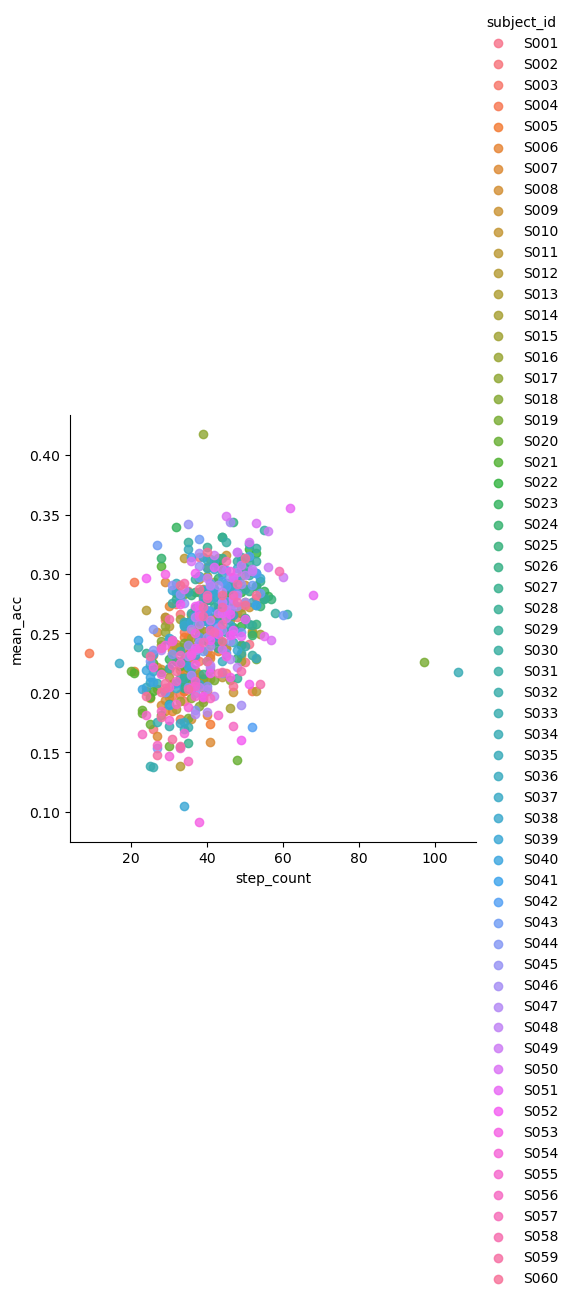

In [6]:
import seaborn as sns
sns.lmplot(data=gait, x="step_count", y="mean_acc", hue="subject_id", lowess=True, fit_reg=False)

In [7]:
gait[["mean_acc", "step_count", "max_acc"]].corr()

,mean_acc,step_count,max_acc
mean_acc,1.000000,0.39622,0.437964
step_count,0.396220,1.00000,0.342680
max_acc,0.437964,0.34268,1.000000


In [8]:
import pandas as pd
import numpy as np

def flag_outliers_subjectwise(
    df,
    value_col,
    subject_col="subject_id",
    date_col="session_date",
    method="zscore",
    z_thresh=3.0,
    iqr_k=1.5,
):
    """
    Adds columns:
      - 'is_outlier' (bool)
      - 'rolling_median' (optional smoothing for plotting)
      - 'residual' (value - rolling_median)
    """
    out = df.copy()
    out = out.sort_values([subject_col, date_col])

    # per-subject rolling median (for visual context, not used in flagging by default)
    out["rolling_median"] = (
        out.groupby(subject_col)[value_col]
          .transform(lambda s: s.rolling(window=3, min_periods=1, center=True).median())
    )
    out["residual"] = out[value_col] - out["rolling_median"]

    def _flag(group):
        s = group[value_col]
        if method == "zscore":
            mu = s.mean()
            sd = s.std(ddof=1)
            if pd.isna(sd) or sd == 0:
                return pd.Series(False, index=group.index)
            z = (s - mu) / sd
            return (z.abs() > z_thresh)
        elif method == "iqr":
            q1 = s.quantile(0.25)
            q3 = s.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_k * iqr
            upper = q3 + iqr_k * iqr
            return (s < lower) | (s > upper)
        else:
            raise ValueError("method must be 'zscore' or 'iqr'.")

    out["is_outlier"] = (
        out.groupby(subject_col, group_keys=False).apply(_flag).reindex(out.index)
    )
    return out

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_subject_timeseries(
    df,
    value_col,
    subject_ids=None,
    subject_col="subject_id",
    date_col="session_date",
    title_prefix=None,
    col_wrap=4,
    height=3,
):
    """
    Small-multiples (one panel per subject). Outliers shown as red points.
    Requires df to already have 'is_outlier' and 'rolling_median' columns.
    """
    d = df.copy()
    if subject_ids is not None:
        d = d[d[subject_col].isin(subject_ids)]

    # If too many subjects, pick the first N to keep the grid readable
    max_panels = 16
    unique_subj = d[subject_col].dropna().unique().tolist()
    if subject_ids is None and len(unique_subj) > max_panels:
        unique_subj = unique_subj[:max_panels]
        d = d[d[subject_col].isin(unique_subj)]

    g = sns.FacetGrid(
        d,
        col=subject_col,
        col_wrap=col_wrap,
        height=height,
        sharex=False,
        sharey=False
    )

    def _panel(data, **kwargs):
        ax = plt.gca()
        # line for raw values
        sns.lineplot(data=data, x=date_col, y=value_col, ax=ax, marker="o", linewidth=1)
        # rolling median for context
        if "rolling_median" in data.columns:
            sns.lineplot(data=data, x=date_col, y="rolling_median", ax=ax, linestyle="--")
        # highlight outliers
        if "is_outlier" in data.columns:
            o = data[data["is_outlier"]]
            ax.scatter(o[date_col], o[value_col], s=35, color="red", zorder=3, label="outlier")
        ax.legend(loc="best", fontsize=8)

    g.map_dataframe(_panel)
    g.set_axis_labels("date", value_col)
    if title_prefix is None:
        title_prefix = f"{value_col} per subject"
    g.fig.suptitle(title_prefix, y=1.02)
    plt.tight_layout()
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\1586273987.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out.groupby(subject_col, group_keys=False).apply(_flag).reindex(out.index)


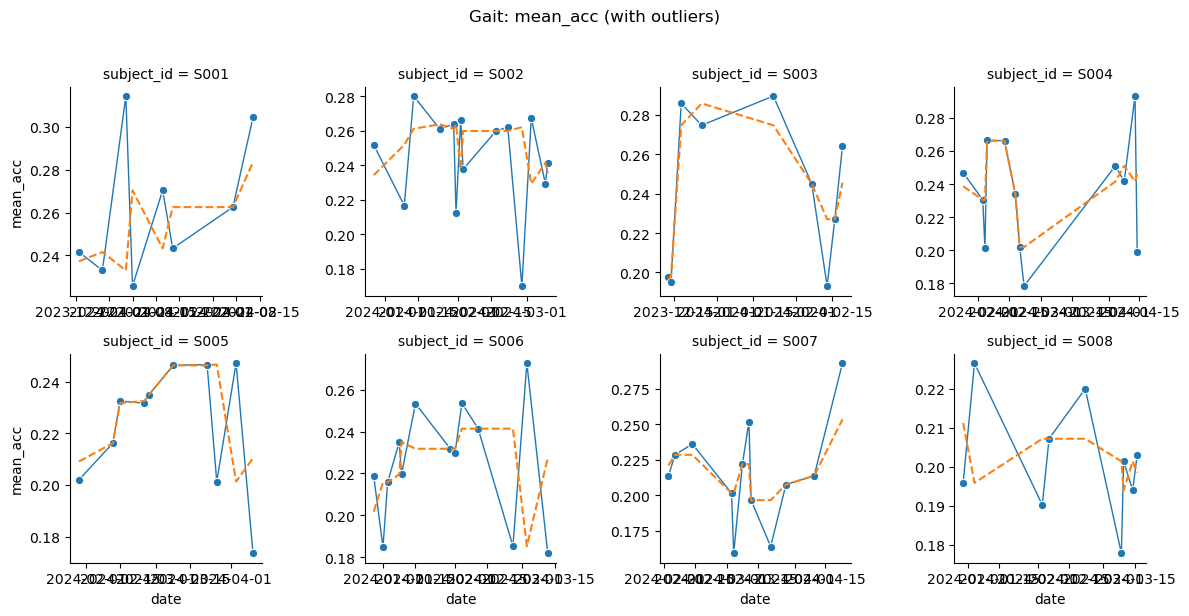

In [10]:
# Ensure dates are parsed
gait = gait.copy()
gait["session_date"] = pd.to_datetime(gait["session_date"])

# Flag outliers per subject using Z-score (try method="iqr" as an alternative)
gait_flagged = flag_outliers_subjectwise(
    gait, value_col="mean_acc", subject_col="subject_id",
    date_col="session_date", method="zscore", z_thresh=3.0
)

# Plot a subset of subjects (or let the function auto-limit to first 16)
some_subjects = gait_flagged["subject_id"].dropna().unique()[:8]
plot_subject_timeseries(
    gait_flagged, value_col="mean_acc", subject_ids=some_subjects,
    subject_col="subject_id", date_col="session_date",
    title_prefix="Gait: mean_acc (with outliers)"
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\1586273987.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out.groupby(subject_col, group_keys=False).apply(_flag).reindex(out.index)


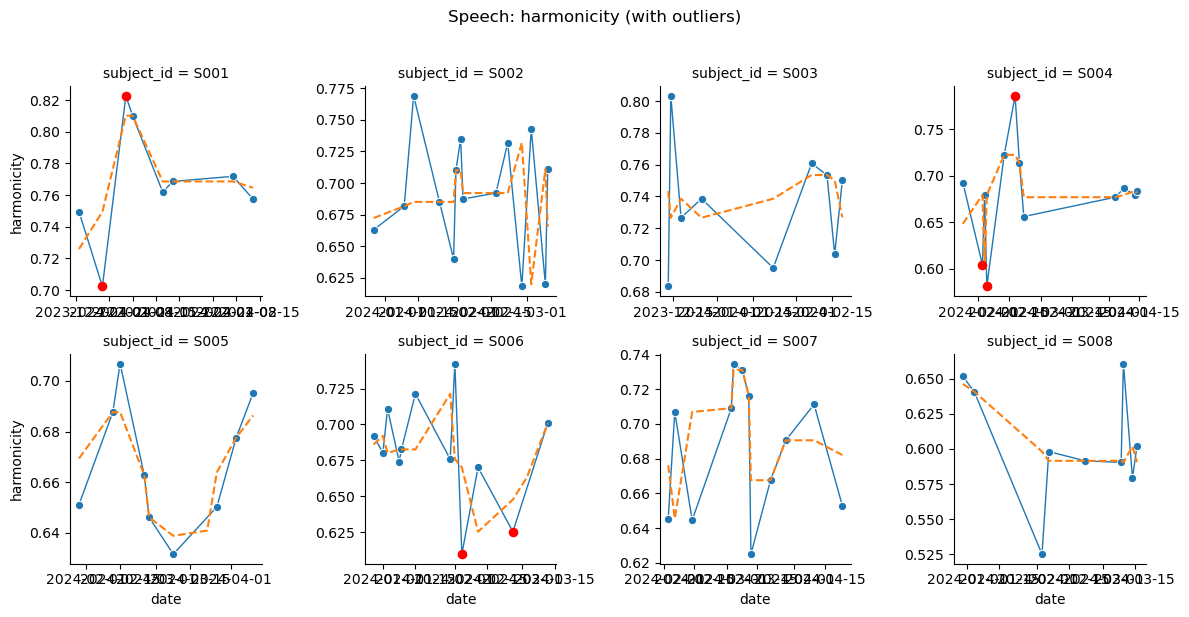

In [11]:
speech = speech.copy()
speech["session_date"] = pd.to_datetime(speech["session_date"])

speech_flagged = flag_outliers_subjectwise(
    speech, value_col="harmonicity", subject_col="subject_id",
    date_col="session_date", method="iqr", iqr_k=1.5
)

some_subjects = speech_flagged["subject_id"].dropna().unique()[:8]
plot_subject_timeseries(
    speech_flagged, value_col="harmonicity", subject_ids=some_subjects,
    subject_col="subject_id", date_col="session_date",
    title_prefix="Speech: harmonicity (with outliers)"
)


In [12]:
from sklearn.linear_model import LinearRegression

def subject_wise_regression_impute(df, target, predictors):
    df_imputed = df.copy()
    for sid, group in df.groupby("subject_id"):
        missing_mask = group[target].isna()
        if missing_mask.sum() == 0:
            continue  # no missing values
        
        # if enough non-missing points, fit regression
        if (~missing_mask).sum() > 3:  
            X_train = group.loc[~missing_mask, predictors]
            y_train = group.loc[~missing_mask, target]
            model = LinearRegression().fit(X_train, y_train)
            
            X_missing = group.loc[missing_mask, predictors]
            y_pred = model.predict(X_missing)
            
            df_imputed.loc[group.loc[missing_mask].index, target] = y_pred
        else:
            # fallback: fill with subject mean
            mean_val = group[target].mean()
            df_imputed.loc[group.loc[missing_mask].index, target] = mean_val
    return df_imputed

# Example:
gait_imputed = subject_wise_regression_impute(gait, target="mean_acc", predictors=["step_count","max_acc"])
speech_imputed = subject_wise_regression_impute(speech, target="harmonicity", predictors=["mean_pitch","voice_breaks"])

In [13]:
# Quick look at missingness per column
print("=== Missingness: gait ===")
print(gait_imputed.isna().sum(), "\n")

print("=== Missingness: speech ===")
print(speech_imputed.isna().sum(), "\n")

# Percentage missing
print("=== % Missing Values: gait ===")
print((gait_imputed.isna().mean() * 100).round(2), "\n")

print("=== % Missing Values: speech ===")
print((speech_imputed.isna().mean() * 100).round(2), "\n")

# # Per subject missingness (useful in longitudinal data)
# print("=== Missing sessions per subject (gait) ===")
# gait_missing = gait_imputed.groupby('subject_id').apply(lambda df: df.isna().mean() * 100)
# print(gait_missing.head(), "\n")

# print("=== Missing sessions per subject (speech) ===")
# speech_missing = speech_imputed.groupby('subject_id').apply(lambda df: df.isna().mean() * 100)
# print(speech_missing.head())

=== Missingness: gait ===
subject_id       0
session_date     0
mean_acc         0
max_acc          0
step_count       0
days_since_dx    0
dtype: int64 

=== Missingness: speech ===
subject_id       0
session_date     0
mean_pitch       0
harmonicity      0
voice_breaks     0
days_since_dx    0
dtype: int64 

=== % Missing Values: gait ===
subject_id       0.0
session_date     0.0
mean_acc         0.0
max_acc          0.0
step_count       0.0
days_since_dx    0.0
dtype: float64 

=== % Missing Values: speech ===
subject_id       0.0
session_date     0.0
mean_pitch       0.0
harmonicity      0.0
voice_breaks     0.0
days_since_dx    0.0
dtype: float64 



In [15]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Example: feature engineering for gait dataset
def engineer_features_gait(gait_df):
    feats = []

    for sid, group in gait_df.groupby("subject_id"):
        group = group.sort_values("session_date")

        # Convert session_date to numeric days since first session
        group["days"] = (pd.to_datetime(group["session_date"]) - 
                         pd.to_datetime(group["session_date"]).min()).dt.days

        # Temporal slope for each variable (linear regression style: Δy/Δx)
        slope_mean_acc = (group["mean_acc"].iloc[-1] - group["mean_acc"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)
        slope_max_acc = (group["max_acc"].iloc[-1] - group["max_acc"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)
        slope_step_count = (group["step_count"].iloc[-1] - group["step_count"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)

        # Baseline-adjusted change (%)
        baseline_mean_acc = group["mean_acc"].iloc[0]
        baseline_max_acc = group["max_acc"].iloc[0]
        baseline_steps = group["step_count"].iloc[0]

        change_mean_acc = (group["mean_acc"].iloc[-1] - baseline_mean_acc) / baseline_mean_acc if baseline_mean_acc != 0 else np.nan
        change_max_acc = (group["max_acc"].iloc[-1] - baseline_max_acc) / baseline_max_acc if baseline_max_acc != 0 else np.nan
        change_step_count = (group["step_count"].iloc[-1] - baseline_steps) / baseline_steps if baseline_steps != 0 else np.nan

        # Variability (std dev & IQR)
        var_mean_acc = group["mean_acc"].std()
        iqr_mean_acc = iqr(group["mean_acc"].dropna())

        var_max_acc = group["max_acc"].std()
        iqr_max_acc = iqr(group["max_acc"].dropna())

        var_steps = group["step_count"].std()
        iqr_steps = iqr(group["step_count"].dropna())

        # Rolling features (last 3 sessions avg & volatility)
        rolling_mean_acc = group["mean_acc"].rolling(window=3).mean().iloc[-1]
        rolling_vol_acc = group["mean_acc"].rolling(window=3).std().iloc[-1]

        feats.append({
            "subject_id": sid,
            "slope_mean_acc": slope_mean_acc,
            "slope_max_acc": slope_max_acc,
            "slope_step_count": slope_step_count,
            "change_mean_acc": change_mean_acc,
            "change_max_acc": change_max_acc,
            "change_step_count": change_step_count,
            "var_mean_acc": var_mean_acc,
            "iqr_mean_acc": iqr_mean_acc,
            "var_max_acc": var_max_acc,
            "iqr_max_acc": iqr_max_acc,
            "var_steps": var_steps,
            "iqr_steps": iqr_steps,
            "rolling_mean_acc": rolling_mean_acc,
            "rolling_vol_acc": rolling_vol_acc
        })

    return pd.DataFrame(feats)


# Example usage
gait_features = engineer_features_gait(gait)
gait_features.head()


,subject_id,slope_mean_acc,slope_max_acc,slope_step_count,change_mean_acc,change_max_acc,change_step_count,var_mean_acc,iqr_mean_acc,var_max_acc,iqr_max_acc,var_steps,iqr_steps,rolling_mean_acc,rolling_vol_acc
0,S001,0.001211,0.001332,-0.038462,0.260616,0.050953,-0.039216,0.032860,0.039491,0.120081,0.127256,6.541079,12.00,0.270138,0.031308
1,S002,-0.000140,0.005335,-0.121622,-0.041099,0.302448,-0.225000,0.029272,0.031971,0.137268,0.158127,7.885513,11.00,0.246063,0.019426
2,S003,0.000975,0.001603,-0.029412,0.335018,0.077225,-0.064516,0.039552,0.076855,0.133334,0.129006,5.172040,7.00,0.228073,0.035538
3,S004,-0.000599,-0.000467,-0.087500,-0.194191,-0.024773,-0.175000,0.033746,0.052994,0.080629,0.131375,11.122936,7.00,0.244518,0.047197
4,S005,-0.000395,-0.001749,0.013889,-0.140704,-0.080686,0.025000,0.024487,0.037940,0.141697,0.209086,4.989990,4.75,0.207313,0.037166


In [17]:
def engineer_features_speech(speech_df):
    feats = []

    for sid, group in speech_df.groupby("subject_id"):
        group = group.sort_values("session_date")

        # Convert session_date to numeric days since first session
        group["days"] = (pd.to_datetime(group["session_date"]) - 
                         pd.to_datetime(group["session_date"]).min()).dt.days

        # Temporal slopes (Δy / Δx)
        slope_pitch = (group["mean_pitch"].iloc[-1] - group["mean_pitch"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)
        slope_harm = (group["harmonicity"].iloc[-1] - group["harmonicity"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)
        slope_breaks = (group["voice_breaks"].iloc[-1] - group["voice_breaks"].iloc[0]) / (group["days"].iloc[-1] - group["days"].iloc[0] + 1e-6)

        # Baseline-adjusted changes (% or relative)
        baseline_pitch = group["mean_pitch"].iloc[0]
        baseline_harm = group["harmonicity"].iloc[0]
        baseline_breaks = group["voice_breaks"].iloc[0]

        change_pitch = (group["mean_pitch"].iloc[-1] - baseline_pitch) / baseline_pitch if baseline_pitch != 0 else np.nan
        change_harm = (group["harmonicity"].iloc[-1] - baseline_harm) / baseline_harm if baseline_harm != 0 else np.nan
        change_breaks = (group["voice_breaks"].iloc[-1] - baseline_breaks) / baseline_breaks if baseline_breaks != 0 else np.nan

        # Variability (std dev & IQR)
        var_pitch = group["mean_pitch"].std()
        iqr_pitch = iqr(group["mean_pitch"].dropna())

        var_harm = group["harmonicity"].std()
        iqr_harm = iqr(group["harmonicity"].dropna())

        var_breaks = group["voice_breaks"].std()
        iqr_breaks = iqr(group["voice_breaks"].dropna())

        # Rolling features (last 3 sessions avg & volatility)
        rolling_pitch_mean = group["mean_pitch"].rolling(window=3).mean().iloc[-1]
        rolling_pitch_vol = group["mean_pitch"].rolling(window=3).std().iloc[-1]

        rolling_harm_mean = group["harmonicity"].rolling(window=3).mean().iloc[-1]
        rolling_harm_vol = group["harmonicity"].rolling(window=3).std().iloc[-1]

        rolling_breaks_mean = group["voice_breaks"].rolling(window=3).mean().iloc[-1]
        rolling_breaks_vol = group["voice_breaks"].rolling(window=3).std().iloc[-1]

        feats.append({
            "subject_id": sid,
            "slope_pitch": slope_pitch,
            "slope_harmonicity": slope_harm,
            "slope_voice_breaks": slope_breaks,
            "change_pitch": change_pitch,
            "change_harmonicity": change_harm,
            "change_voice_breaks": change_breaks,
            "var_pitch": var_pitch,
            "iqr_pitch": iqr_pitch,
            "var_harmonicity": var_harm,
            "iqr_harmonicity": iqr_harm,
            "var_voice_breaks": var_breaks,
            "iqr_voice_breaks": iqr_breaks,
            "rolling_pitch_mean": rolling_pitch_mean,
            "rolling_pitch_vol": rolling_pitch_vol,
            "rolling_harm_mean": rolling_harm_mean,
            "rolling_harm_vol": rolling_harm_vol,
            "rolling_breaks_mean": rolling_breaks_mean,
            "rolling_breaks_vol": rolling_breaks_vol
        })

    return pd.DataFrame(feats)


# Example usage
speech_features = engineer_features_speech(speech)
speech_features.head()

,subject_id,slope_pitch,slope_harmonicity,slope_voice_breaks,change_pitch,change_harmonicity,change_voice_breaks,var_pitch,iqr_pitch,var_harmonicity,iqr_harmonicity,var_voice_breaks,iqr_voice_breaks,rolling_pitch_mean,rolling_pitch_vol,rolling_harm_mean,rolling_harm_vol,rolling_breaks_mean,rolling_breaks_vol
0,S001,0.188756,0.000152,0.038462,0.089716,0.010532,0.285714,6.245384,4.705776,0.037020,0.025946,1.927248,2.25,114.442248,4.699818,0.765937,0.007549,9.333333,1.527525
1,S002,0.251366,0.000647,0.040541,0.158724,0.072225,0.428571,10.703786,7.795477,0.045564,0.058967,2.773501,4.75,124.742233,12.154205,0.691216,0.063764,11.666667,1.527525
2,S003,0.076295,0.000982,0.000000,0.050470,0.097761,0.000000,7.042928,9.460739,0.037471,0.049980,2.773886,4.00,110.785909,8.607672,0.735716,0.027955,10.000000,2.645751
3,S004,-0.082812,-0.000112,0.012500,-0.039532,-0.012920,0.076923,7.404759,7.955296,0.052708,0.026205,1.781640,2.25,154.072974,6.461285,0.683243,0.003595,11.000000,3.000000
4,S005,-0.129562,0.000611,0.027778,-0.053898,0.067609,0.142857,8.288824,11.604249,0.025362,0.037393,2.078995,2.50,157.953240,5.412260,0.674316,0.022622,14.666667,1.154701


In [19]:
import pandas as pd

# 1. Start with subjects (base table)
master = su.copy()

# 2. Merge outcomes (target variable)
master = master.merge(oc, on="subject_id", how="inner")

# 3. Merge gait engineered features
# (assuming gait_features is already aggregated per subject_id)
master = master.merge(gait_features, on="subject_id", how="inner")

# 4. Merge speech engineered features
# (assuming speech_features is already aggregated per subject_id)
master = master.merge(speech_features, on="subject_id", how="inner")

# 5. Quick checks
print("Master dataset shape:", master.shape)
# Check missing values
print(master.isna().sum())
master.head()

Master dataset shape: (60, 38)
subject_id             0
sex                    0
age                    0
diagnosis_date         0
age_bin                0
outcome                0
slope_mean_acc         4
slope_max_acc          0
slope_step_count       0
change_mean_acc        4
change_max_acc         0
change_step_count      0
var_mean_acc           0
iqr_mean_acc           0
var_max_acc            0
iqr_max_acc            0
var_steps              0
iqr_steps              0
rolling_mean_acc       4
rolling_vol_acc        4
slope_pitch            0
slope_harmonicity      1
slope_voice_breaks     0
change_pitch           0
change_harmonicity     1
change_voice_breaks    0
var_pitch              0
iqr_pitch              0
var_harmonicity        0
iqr_harmonicity        0
var_voice_breaks       0
iqr_voice_breaks       0
rolling_pitch_mean     0
rolling_pitch_vol      0
rolling_harm_mean      5
rolling_harm_vol       5
rolling_breaks_mean    0
rolling_breaks_vol     0
dtype: int64


,subject_id,sex,age,diagnosis_date,age_bin,outcome,slope_mean_acc,slope_max_acc,slope_step_count,change_mean_acc,...,var_harmonicity,iqr_harmonicity,var_voice_breaks,iqr_voice_breaks,rolling_pitch_mean,rolling_pitch_vol,rolling_harm_mean,rolling_harm_vol,rolling_breaks_mean,rolling_breaks_vol
0,S001,M,57,2023-12-08,50-69,1,0.001211,0.001332,-0.038462,0.260616,...,0.037020,0.025946,1.927248,2.25,114.442248,4.699818,0.765937,0.007549,9.333333,1.527525
1,S002,M,66,2023-12-21,50-69,0,-0.000140,0.005335,-0.121622,-0.041099,...,0.045564,0.058967,2.773501,4.75,124.742233,12.154205,0.691216,0.063764,11.666667,1.527525
2,S003,M,54,2023-12-11,50-69,0,0.000975,0.001603,-0.029412,0.335018,...,0.037471,0.049980,2.773886,4.00,110.785909,8.607672,0.735716,0.027955,10.000000,2.645751
3,S004,F,61,2024-01-22,50-69,1,-0.000599,-0.000467,-0.087500,-0.194191,...,0.052708,0.026205,1.781640,2.25,154.072974,6.461285,0.683243,0.003595,11.000000,3.000000
4,S005,F,65,2024-01-22,50-69,1,-0.000395,-0.001749,0.013889,-0.140704,...,0.025362,0.037393,2.078995,2.50,157.953240,5.412260,0.674316,0.022622,14.666667,1.154701


In [20]:
# Find subjects with any missing values
subjects_with_nulls = master[master.isna().any(axis=1)]

# For each subject, list missing features
for idx, row in subjects_with_nulls.iterrows():
    missing_feats = row[row.isna()].index.tolist()
    print(f"Subject {row['subject_id']} has missing values in: {missing_feats}")


Subject S006 has missing values in: ['rolling_harm_mean', 'rolling_harm_vol']
Subject S014 has missing values in: ['rolling_mean_acc', 'rolling_vol_acc']
Subject S024 has missing values in: ['slope_mean_acc', 'change_mean_acc', 'rolling_mean_acc', 'rolling_vol_acc']
Subject S032 has missing values in: ['slope_harmonicity', 'change_harmonicity', 'rolling_harm_mean', 'rolling_harm_vol']
Subject S037 has missing values in: ['rolling_harm_mean', 'rolling_harm_vol']
Subject S041 has missing values in: ['rolling_harm_mean', 'rolling_harm_vol']
Subject S045 has missing values in: ['slope_mean_acc', 'change_mean_acc', 'rolling_mean_acc', 'rolling_vol_acc', 'rolling_harm_mean', 'rolling_harm_vol']
Subject S053 has missing values in: ['slope_mean_acc', 'change_mean_acc', 'rolling_mean_acc', 'rolling_vol_acc']
Subject S057 has missing values in: ['slope_mean_acc', 'change_mean_acc']


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def check_regression_strength(df, target_col, predictor_cols):
    """
    Evaluate how well predictors explain a missing-value feature.
    Prints R² and returns the trained model.
    """
    # Drop rows where target is missing
    data = df.dropna(subset=[target_col])
    
    X = data[predictor_cols]
    y = data[target_col]
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    r2 = r2_score(y, y_pred)
    print(f"Target = {target_col}, Predictors = {predictor_cols}, R² = {r2:.3f}")
    return model, r2


In [22]:
# For gait features
check_regression_strength(master, "slope_mean_acc", ["slope_max_acc", "slope_step_count"])
check_regression_strength(master, "change_mean_acc", ["change_max_acc", "change_step_count"])
check_regression_strength(master, "rolling_mean_acc", ["slope_max_acc", "slope_step_count"])
check_regression_strength(master, "rolling_vol_acc", ["var_steps", "var_max_acc"])

# For speech features
check_regression_strength(master, "slope_harmonicity", ["slope_pitch", "slope_voice_breaks"])
check_regression_strength(master, "change_harmonicity", ["change_pitch", "change_voice_breaks"])
check_regression_strength(master, "rolling_harm_mean", ["rolling_pitch_mean", "rolling_breaks_mean"])
check_regression_strength(master, "rolling_harm_vol", ["rolling_pitch_vol", "rolling_breaks_vol"])


Target = slope_mean_acc, Predictors = ['slope_max_acc', 'slope_step_count'], R² = 0.035
Target = change_mean_acc, Predictors = ['change_max_acc', 'change_step_count'], R² = 0.054
Target = rolling_mean_acc, Predictors = ['slope_max_acc', 'slope_step_count'], R² = 0.043
Target = rolling_vol_acc, Predictors = ['var_steps', 'var_max_acc'], R² = 0.009
Target = slope_harmonicity, Predictors = ['slope_pitch', 'slope_voice_breaks'], R² = 0.038
Target = change_harmonicity, Predictors = ['change_pitch', 'change_voice_breaks'], R² = 0.037
Target = rolling_harm_mean, Predictors = ['rolling_pitch_mean', 'rolling_breaks_mean'], R² = 0.721
Target = rolling_harm_vol, Predictors = ['rolling_pitch_vol', 'rolling_breaks_vol'], R² = 0.158


(LinearRegression(), 0.1578341608922833)

In [23]:
def cohort_median_impute(df, target_col, group_cols=["age_bin", "sex"]):
    """
    Impute missing values in target_col using median per cohort (age_bin + sex).
    """
    df[target_col] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.fillna(x.median())
    )
    return df

# Apply for weak R² features
for col in ["slope_mean_acc", "change_mean_acc", "rolling_mean_acc", "rolling_vol_acc",
            "slope_harmonicity", "change_harmonicity", "rolling_harm_vol"]:
    master = cohort_median_impute(master, col)


C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\3808382187.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[target_col] = df.groupby(group_cols)[target_col].transform(
C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\3808382187.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[target_col] = df.groupby(group_cols)[target_col].transform(
C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\3808382187.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np

def regression_impute(df, target_col, predictor_cols):
    """
    Impute missing values in target_col using linear regression on predictor_cols.
    """
    # Split into non-missing and missing subsets
    train_df = df.dropna(subset=[target_col])
    test_df = df[df[target_col].isna()]
    
    if len(test_df) == 0:
        return df
    
    X_train = train_df[predictor_cols]
    y_train = train_df[target_col]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict for missing rows
    X_test = test_df[predictor_cols]
    y_pred = model.predict(X_test)
    
    # Fill in missing values
    df.loc[df[target_col].isna(), target_col] = y_pred
    return df

# Apply regression imputation only for rolling_harm_mean
master = regression_impute(master, "rolling_harm_mean", ["rolling_pitch_mean", "rolling_breaks_mean"])


In [25]:
from scipy.stats import zscore

# Select only numeric engineered features
numeric_feats = master.select_dtypes(include='number').drop(columns=["age"])  # keep relevant only

# Calculate Z-scores per feature
z_scores = numeric_feats.apply(zscore)

# Flag values > 3 std devs as outliers
outliers = (abs(z_scores) > 3)

# Count per feature
outlier_counts = outliers.sum().sort_values(ascending=False)
print(outlier_counts)


var_steps              2
rolling_breaks_vol     1
var_mean_acc           1
var_harmonicity        1
rolling_vol_acc        1
change_voice_breaks    1
iqr_mean_acc           1
var_pitch              1
change_step_count      1
rolling_harm_vol       1
slope_step_count       1
rolling_harm_mean      0
rolling_pitch_mean     0
iqr_voice_breaks       0
var_voice_breaks       0
iqr_harmonicity        0
rolling_breaks_mean    0
iqr_pitch              0
rolling_pitch_vol      0
outcome                0
change_harmonicity     0
change_pitch           0
slope_voice_breaks     0
slope_mean_acc         0
slope_pitch            0
rolling_mean_acc       0
iqr_steps              0
iqr_max_acc            0
var_max_acc            0
change_max_acc         0
change_mean_acc        0
slope_max_acc          0
slope_harmonicity      0
dtype: int64


In [27]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

def mahalanobis_outliers(df, features, alpha=0.01):
    """
    Identify outliers using Mahalanobis distance across multiple features.
    Returns features with outliers flagged.
    """
    X = df[features].dropna()
    cov_matrix = np.cov(X.values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_vec = X.mean(axis=0).values
    
    # Compute Mahalanobis distance for each row
    m_dist = X.apply(lambda row: mahalanobis(row.values, mean_vec, inv_cov_matrix), axis=1)
    
    # Chi-square threshold (p-value cutoff)
    threshold = chi2.ppf((1 - alpha), df=len(features))
    
    # Flag outliers
    outliers = m_dist > np.sqrt(threshold)
    return outliers, m_dist

# Example usage on engineered features
engineered_feats = [
    "slope_mean_acc", "change_mean_acc", "rolling_mean_acc", "rolling_vol_acc",
    "slope_harmonicity", "change_harmonicity", "rolling_harm_mean", "rolling_harm_vol"
]

outlier_flags, md_scores = mahalanobis_outliers(master, engineered_feats)

# Add results back into df
master["MD_score"] = md_scores
master["MD_outlier"] = outlier_flags

# Output which features are driving outliers
print("Multivariate outliers detected in subjects:", master.loc[master["MD_outlier"], "subject_id"].unique())


Multivariate outliers detected in subjects: ['S013' 'S017' 'S054' 'S059']


In [30]:
master.where(master['MD_outlier']==True).dropna()

,subject_id,sex,age,diagnosis_date,age_bin,outcome,slope_mean_acc,slope_max_acc,slope_step_count,change_mean_acc,...,var_voice_breaks,iqr_voice_breaks,rolling_pitch_mean,rolling_pitch_vol,rolling_harm_mean,rolling_harm_vol,rolling_breaks_mean,rolling_breaks_vol,MD_score,MD_outlier
12,S013,M,57.0,2024-01-22,50-69,1.0,-0.000335,0.001745,-0.055556,-0.075863,...,3.032234,5.00,111.333158,7.328249,0.727026,0.081503,14.000000,2.000000,5.291798,True
16,S017,M,60.0,2024-01-09,50-69,1.0,-0.000671,0.002130,0.000000,-0.162713,...,1.928652,2.25,120.753860,12.469851,0.771253,0.048795,10.333333,1.527525,5.031808,True
53,S054,M,64.0,2024-01-20,50-69,1.0,0.001094,0.002773,0.100000,0.493020,...,1.265924,1.00,111.312843,3.132247,0.661607,0.070064,13.666667,0.577350,5.111679,True
58,S059,F,61.0,2024-01-18,50-69,1.0,-0.000631,0.000616,-0.026316,-0.235999,...,1.377474,1.00,150.589075,15.060780,0.683508,0.163427,14.333333,2.516611,5.235533,True


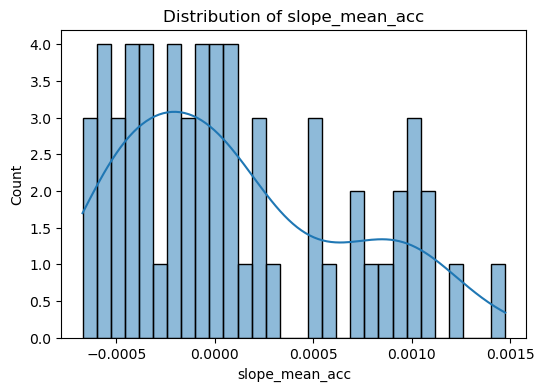

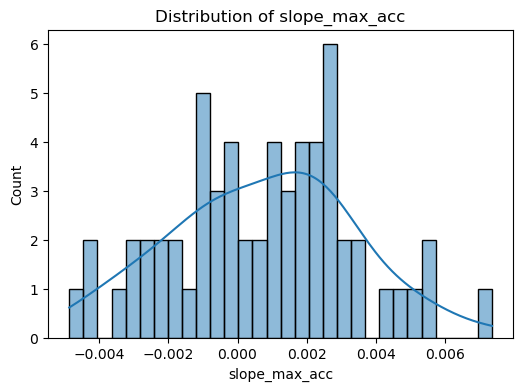

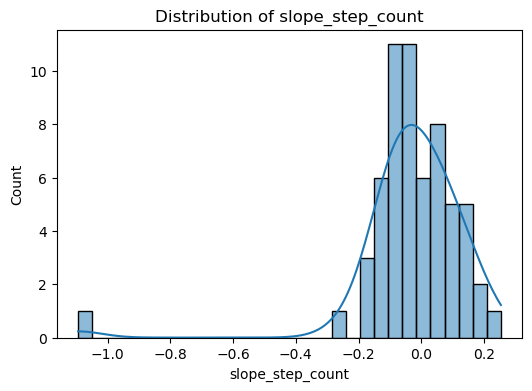

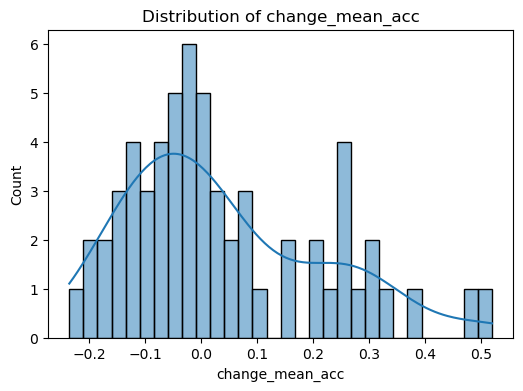

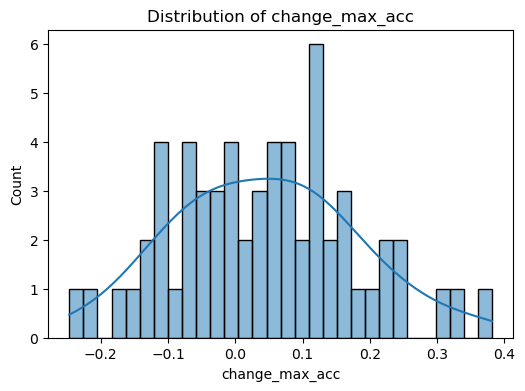

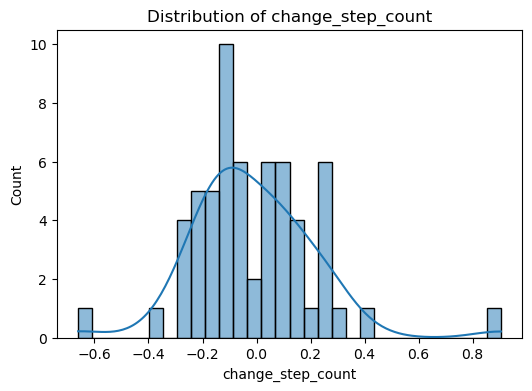

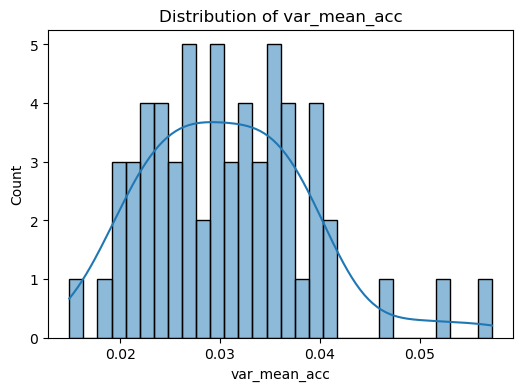

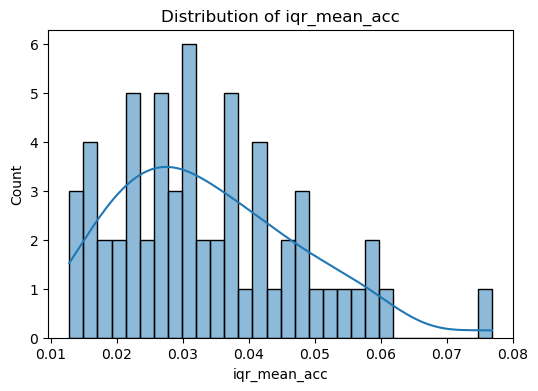

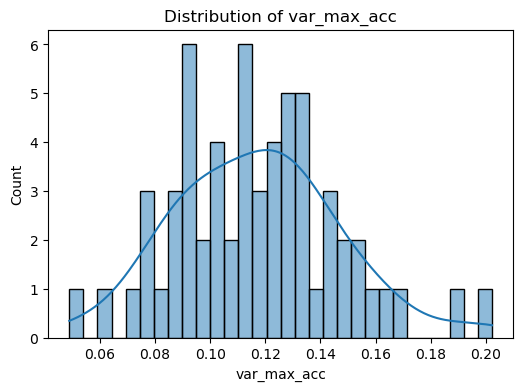

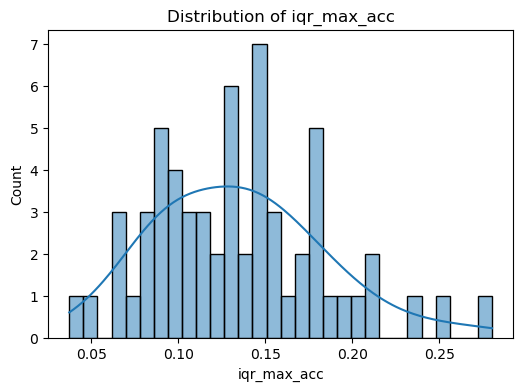

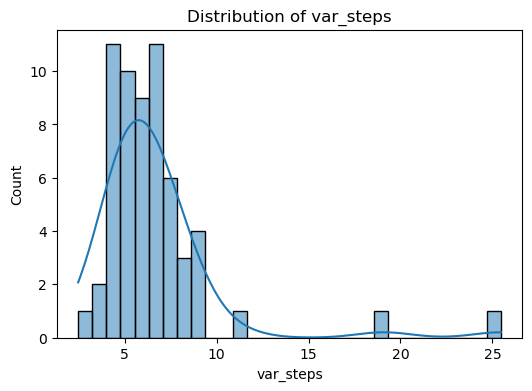

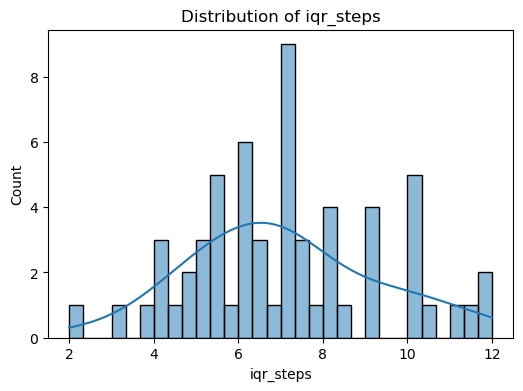

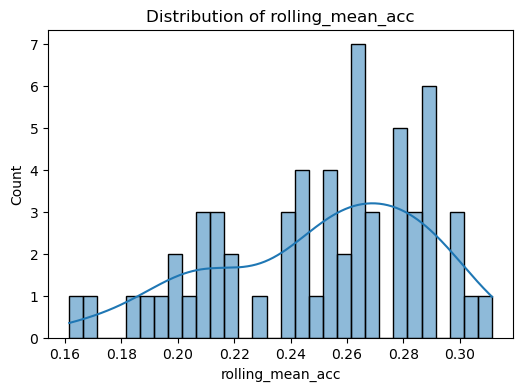

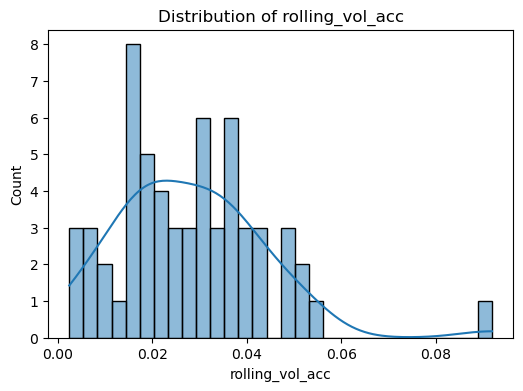

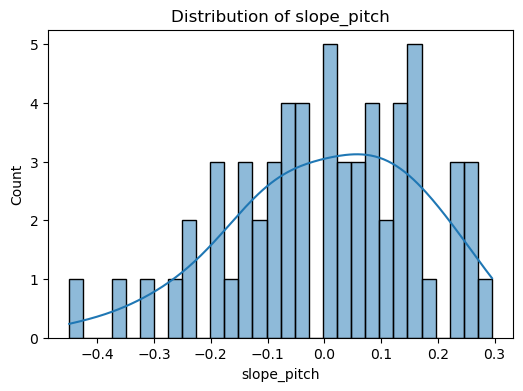

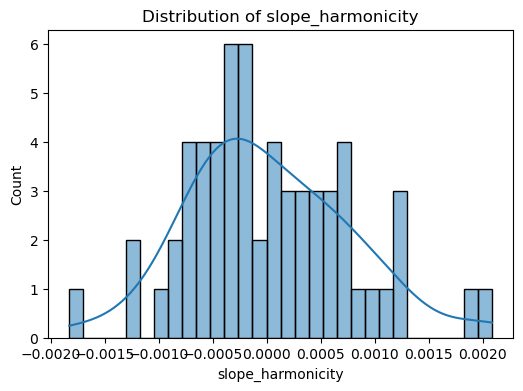

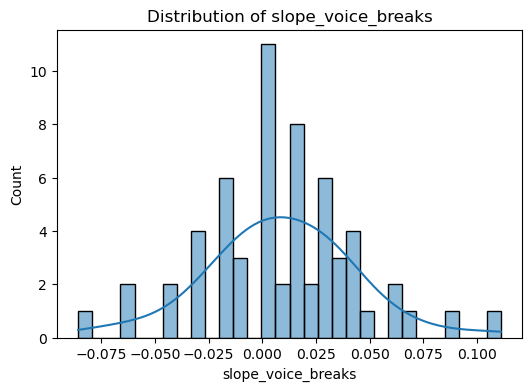

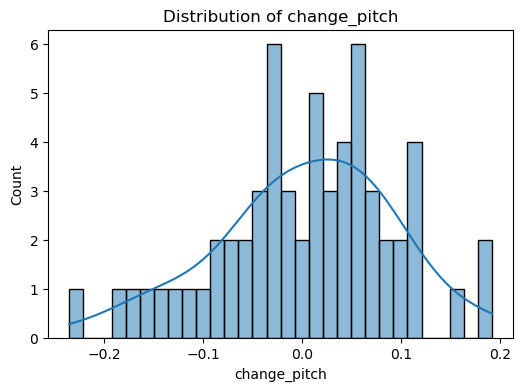

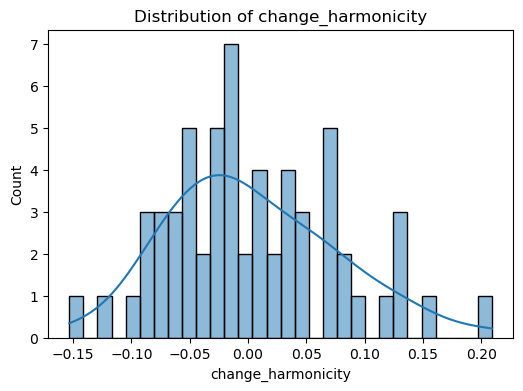

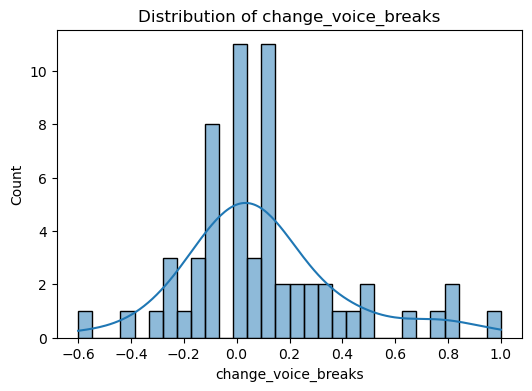

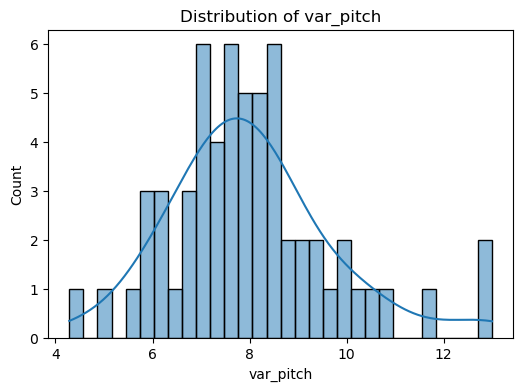

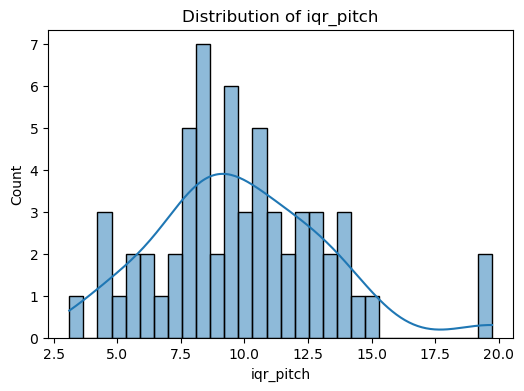

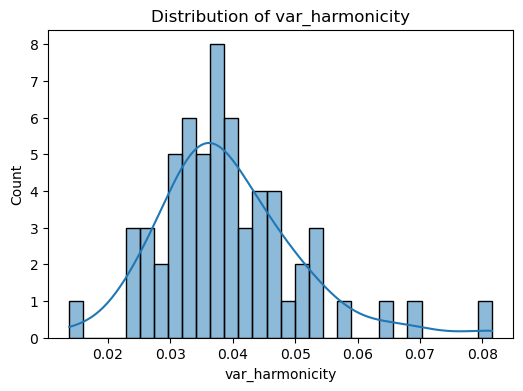

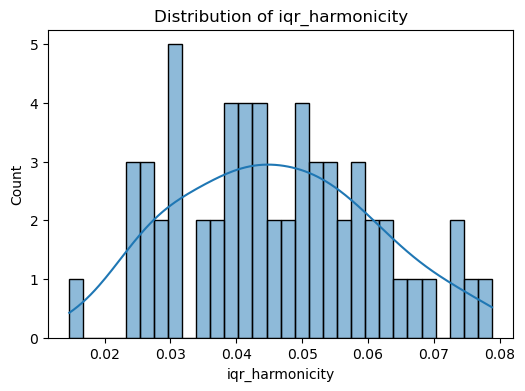

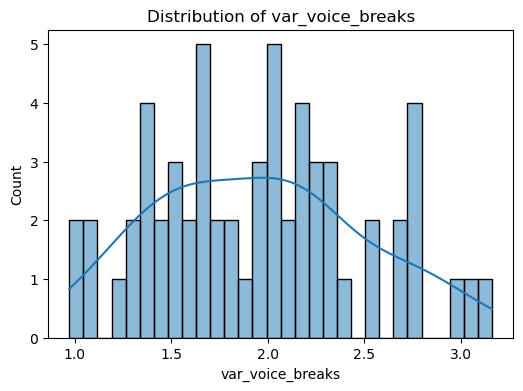

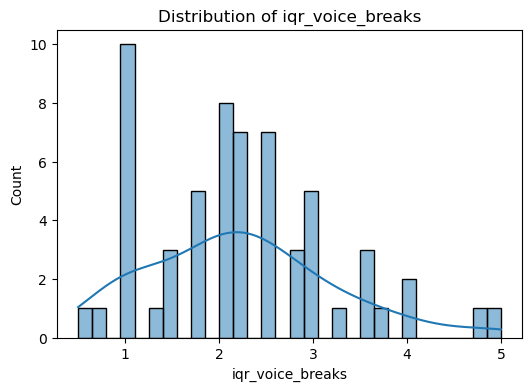

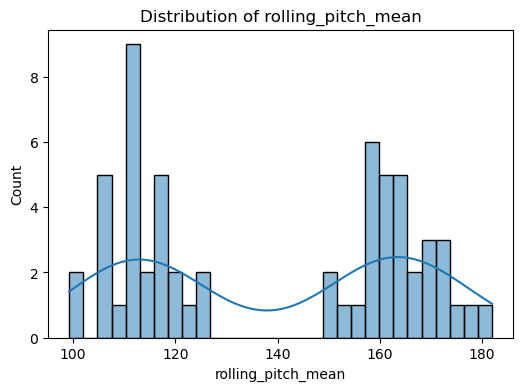

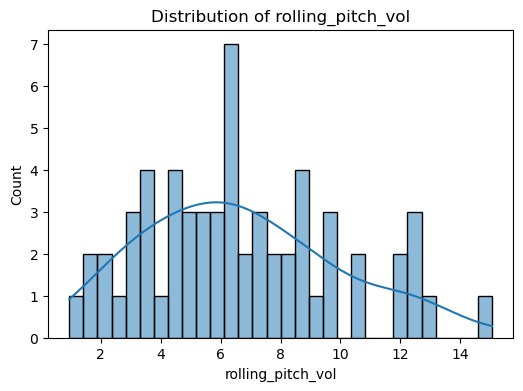

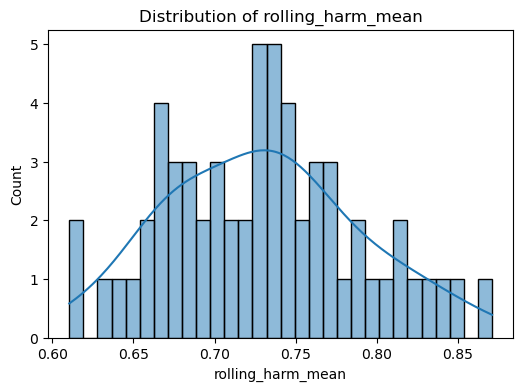

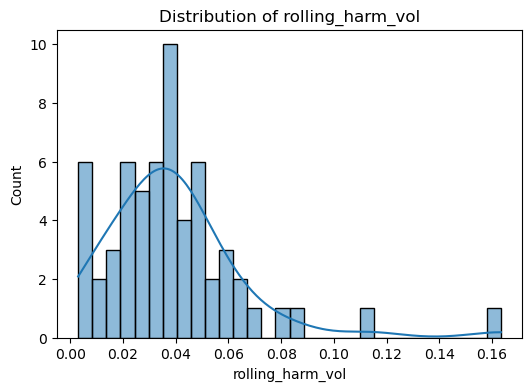

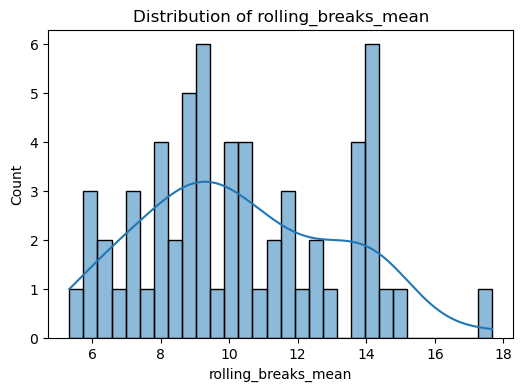

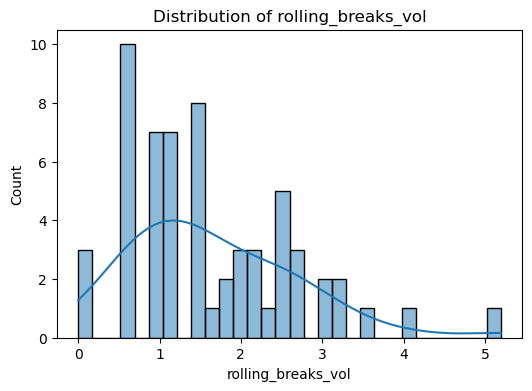

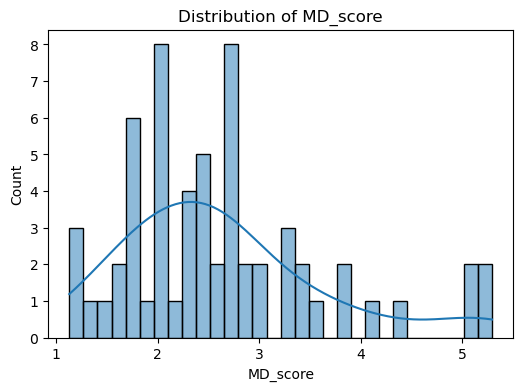

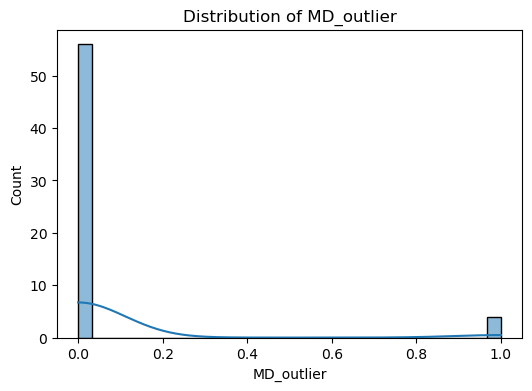

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select engineered features only (exclude id/sex/age/outcome)
engineered_feats = [col for col in master.columns if col not in ['subject_id', 'sex', 'age', 'diagnosis_date', 'age_bin', 'outcome']]

# Plot histograms with KDE for each feature
for feat in engineered_feats:
    plt.figure(figsize=(6, 4))
    sns.histplot(master[feat], kde=True, bins=30)
    plt.title(f"Distribution of {feat}")
    plt.show()


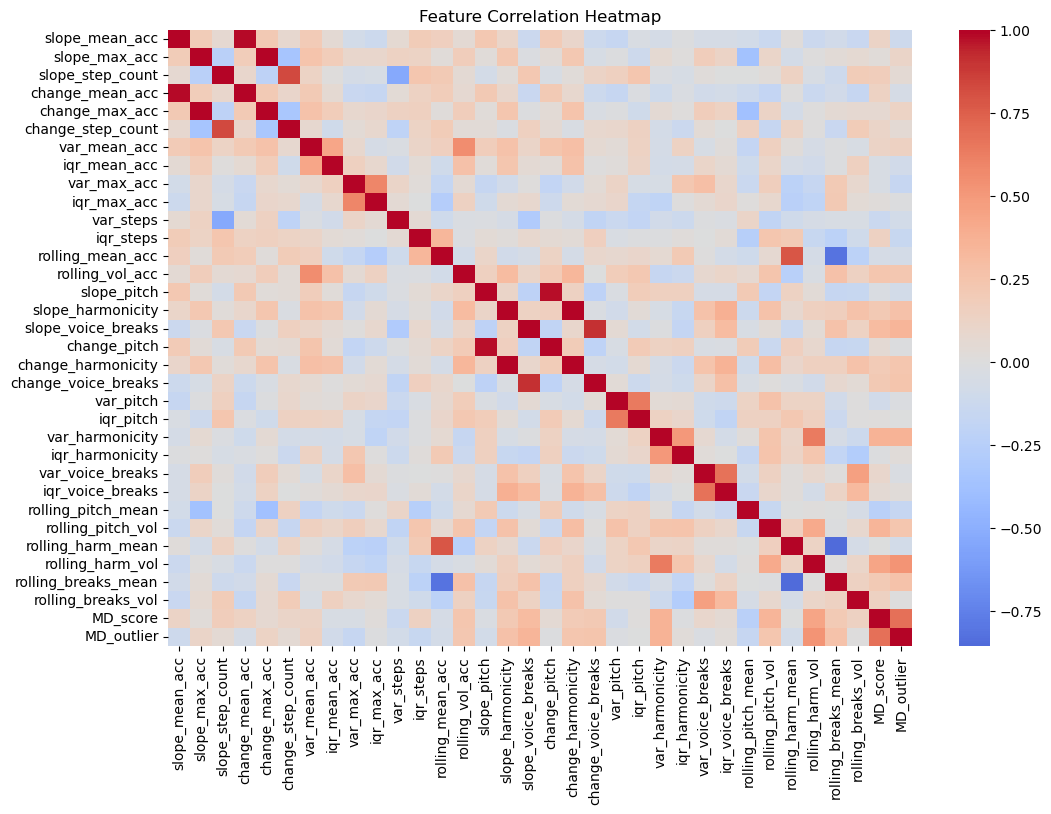

In [32]:
# Compute correlation matrix
corr_matrix = master[engineered_feats].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [33]:
# Find pairs with correlation > 0.8
threshold = 0.8
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]
print(high_corr)


               Feature1             Feature2  Correlation
2        slope_mean_acc      change_mean_acc     0.978910
35        slope_max_acc       change_max_acc     0.987965
67     slope_step_count    change_step_count     0.827569
347    rolling_mean_acc  rolling_breaks_mean    -0.817688
373         slope_pitch         change_pitch     0.975652
392   slope_harmonicity   change_harmonicity     0.990254
410  slope_voice_breaks  change_voice_breaks     0.913024
547   rolling_harm_mean  rolling_breaks_mean    -0.855066


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

# ---------------------------
# 1. Prepare Logistic Regression Dataset
# ---------------------------
# Drop highly correlated "change_*" features and redundant rolling ones
drop_feats = [col for col in master.columns if col.startswith("change_")] + [
    "rolling_breaks_mean",  # redundant with rolling_mean_acc
    "rolling_harm_mean"     # redundant with rolling_breaks_mean
]

master_2 = master.drop(columns=drop_feats)

# Features and target
X_log = master_2.drop(columns=["subject_id", "sex", "age", "diagnosis_date", "age_bin", "outcome"])
y_log = master_2["outcome"]

# Standardize features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Train-test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log_scaled, y_log, test_size=0.2, random_state=42, stratify=y_log
)

# Logistic Regression with regularization
log_reg = LogisticRegression(max_iter=500, solver="liblinear")
log_reg.fit(X_train_log, y_train_log)

# Predictions
y_pred_log = log_reg.predict(X_test_log)
y_proba_log = log_reg.predict_proba(X_test_log)[:,1]

# Scores
print("=== Logistic Regression Baseline ===")
print("Accuracy:", accuracy_score(y_test_log, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test_log, y_proba_log))
print("F1:", f1_score(y_test_log, y_pred_log))
print(classification_report(y_test_log, y_pred_log))


# ---------------------------
# 2. Prepare Random Forest Dataset
# ---------------------------
X_rf = master.drop(columns=["subject_id", "sex", "age", "diagnosis_date", "age_bin", "outcome"])
y_rf = master["outcome"]

# Train-test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf = rf.predict(X_test_rf)
y_proba_rf = rf.predict_proba(X_test_rf)[:,1]

# Scores
print("\n=== Random Forest Baseline ===")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test_rf, y_proba_rf))
print("F1:", f1_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))


=== Logistic Regression Baseline ===
Accuracy: 0.5
ROC AUC: 0.9142857142857144
F1: 0.625
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.45      1.00      0.62         5

    accuracy                           0.50        12
   macro avg       0.73      0.57      0.44        12
weighted avg       0.77      0.50      0.41        12


=== Random Forest Baseline ===
Accuracy: 0.8333333333333334
ROC AUC: 0.8571428571428571
F1: 0.8
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



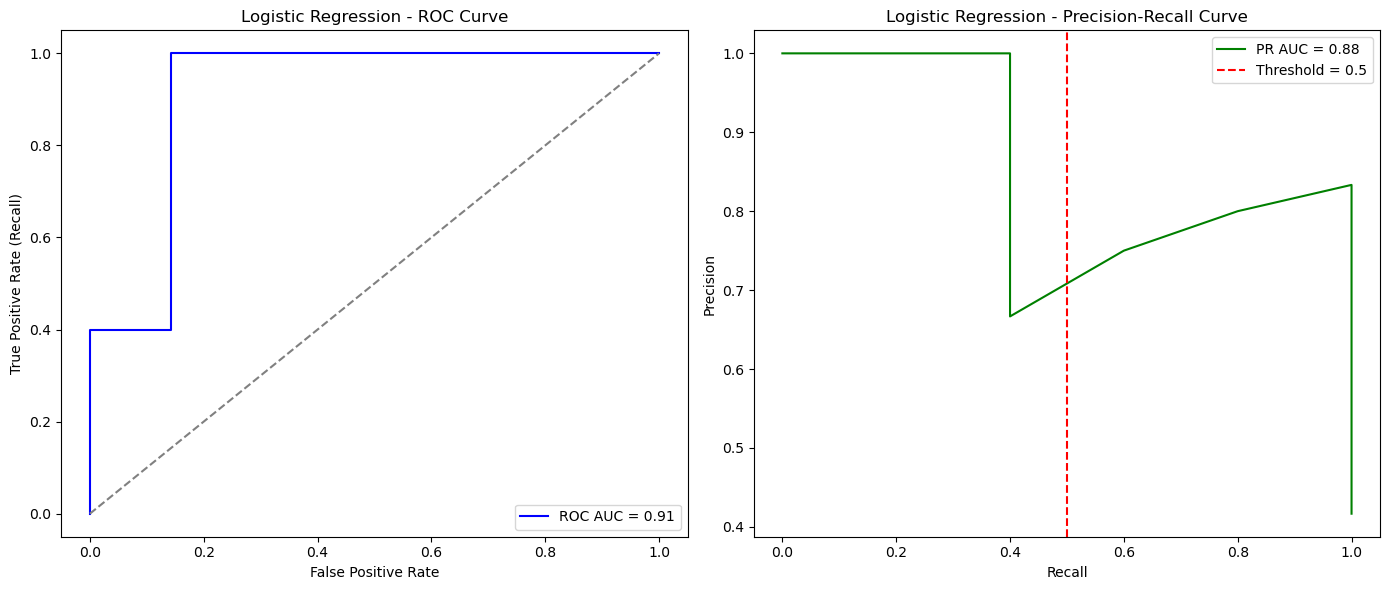

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# =========================
# ROC Curve for Logistic Regression
# =========================
fpr, tpr, _ = roc_curve(y_test_log, y_proba_log)
roc_auc = auc(fpr, tpr)

# =========================
# Precision-Recall Curve
# =========================
precision, recall, thresholds = precision_recall_curve(y_test_log, y_proba_log)
pr_auc = average_precision_score(y_test_log, y_proba_log)

# =========================
# Plot Both
# =========================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color="blue", label=f"ROC AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("Logistic Regression - ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].legend(loc="lower right")

# Precision-Recall Curve
axes[1].plot(recall, precision, color="green", label=f"PR AUC = {pr_auc:.2f}")
axes[1].axvline(x=0.5, linestyle="--", color="red", label="Threshold = 0.5")  # marker for default threshold
axes[1].set_title("Logistic Regression - Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


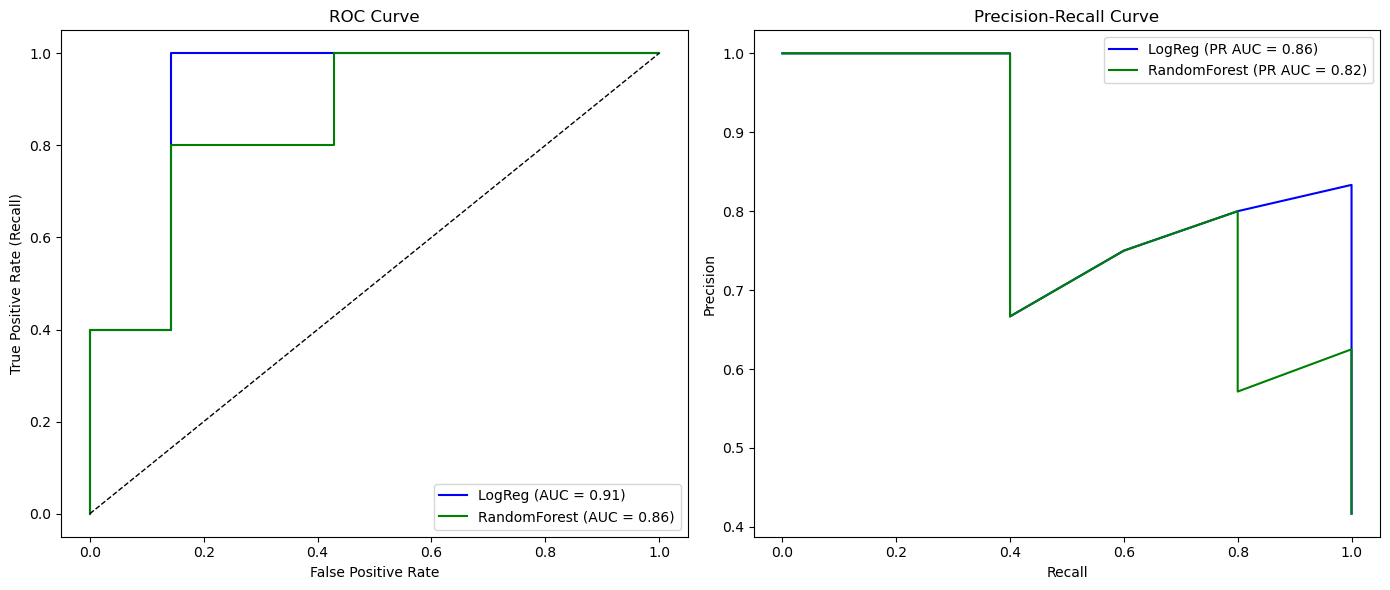

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- ROC Curves ---
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# --- Precision-Recall Curves ---
prec_log, rec_log, _ = precision_recall_curve(y_test_log, y_proba_log)
pr_auc_log = auc(rec_log, prec_log)

prec_rf, rec_rf, _ = precision_recall_curve(y_test_rf, y_proba_rf)
pr_auc_rf = auc(rec_rf, prec_rf)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. ROC Curve
axes[0].plot(fpr_log, tpr_log, label=f"LogReg (AUC = {roc_auc_log:.2f})", color="blue")
axes[0].plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {roc_auc_rf:.2f})", color="green")
axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].legend(loc="lower right")

# 2. Precision-Recall Curve
axes[1].plot(rec_log, prec_log, label=f"LogReg (PR AUC = {pr_auc_log:.2f})", color="blue")
axes[1].plot(rec_rf, prec_rf, label=f"RandomForest (PR AUC = {pr_auc_rf:.2f})", color="green")
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Logistic Regression with regularization
param_grid_log = {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"], "solver": ["liblinear"]}
grid_log = GridSearchCV(LogisticRegression(max_iter=1000, class_weight="balanced"),
                        param_grid_log, cv=5, scoring="roc_auc")
grid_log.fit(X_train_log, y_train_log)
best_log = grid_log.best_estimator_

print("Best Logistic Regression:", grid_log.best_params_)
y_pred_log = best_log.predict(X_test_log)
y_proba_log = best_log.predict_proba(X_test_log)[:,1]
print("ROC AUC:", roc_auc_score(y_test_log, y_proba_log))
print("F1:", f1_score(y_test_log, y_pred_log))
print(classification_report(y_test_log, y_pred_log))

# Random Forest with tuned depth and leaf size
param_grid_rf = {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
                       param_grid_rf, cv=5, scoring="roc_auc")
grid_rf.fit(X_train_rf, y_train_rf)
best_rf = grid_rf.best_estimator_

print("Best Random Forest:", grid_rf.best_params_)
y_pred_rf = best_rf.predict(X_test_rf)
y_proba_rf = best_rf.predict_proba(X_test_rf)[:,1]
print("ROC AUC:", roc_auc_score(y_test_rf, y_proba_rf))
print("F1:", f1_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))

# XGBoost
xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_rf, y_train_rf)

y_pred_xgb = xgb.predict(X_test_rf)
y_proba_xgb = xgb.predict_proba(X_test_rf)[:,1]

print("\n=== XGBoost ===")
print("ROC AUC:", roc_auc_score(y_test_rf, y_proba_xgb))
print("F1:", f1_score(y_test_rf, y_pred_xgb))
print(classification_report(y_test_rf, y_pred_xgb))


Best Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC: 0.9714285714285715
F1: 0.7142857142857143
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.56      1.00      0.71         5

    accuracy                           0.67        12
   macro avg       0.78      0.71      0.66        12
weighted avg       0.81      0.67      0.65        12

Best Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
ROC AUC: 0.7999999999999999
F1: 0.8
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12


=== XGBoost ===
ROC AUC: 0.6285714285714286
F1: 0.6
              precision    recall  f1-score  


=== Logistic Regression Odds Ratios ===
               Feature  OddsRatio
24            MD_score   2.566269
10     rolling_vol_acc   1.923771
25          MD_outlier   1.815433
21   rolling_pitch_vol   1.379214
23  rolling_breaks_vol   1.364398
11         slope_pitch   1.281958
1        slope_max_acc   1.220833
5          var_max_acc   0.956833
12   slope_harmonicity   0.956547
6          iqr_max_acc   0.895685
4         iqr_mean_acc   0.800099
16     var_harmonicity   0.752201
8            iqr_steps   0.740105
14           var_pitch   0.706889
19    iqr_voice_breaks   0.697031
20  rolling_pitch_mean   0.661513
17     iqr_harmonicity   0.658264
7            var_steps   0.634984
15           iqr_pitch   0.623752
13  slope_voice_breaks   0.591971
0       slope_mean_acc   0.589039
3         var_mean_acc   0.557538
22    rolling_harm_vol   0.556457
18    var_voice_breaks   0.546386
9     rolling_mean_acc   0.305210
2     slope_step_count   0.261222

=== Random Forest Feature Importances ==

C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\1278484116.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances.head(10), x="Importance", y="Feature", palette="viridis")


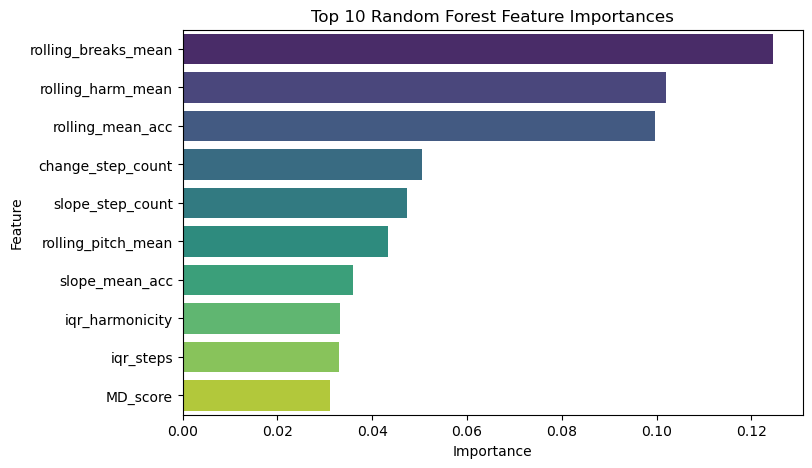

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:47:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\DELL\AppData\Local\Temp\ipykernel_17620\1278484116.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_importances.head(10), x="Importance", y="Feature", palette="mako")



=== XGBoost Feature Importances ===
                Feature  Importance
3       change_mean_acc    0.246436
30  rolling_breaks_mean    0.193251
2      slope_step_count    0.099254
14          slope_pitch    0.085040
22      var_harmonicity    0.041957
26   rolling_pitch_mean    0.041809
23      iqr_harmonicity    0.041275
8           var_max_acc    0.032611
1         slope_max_acc    0.028311
7          iqr_mean_acc    0.026454


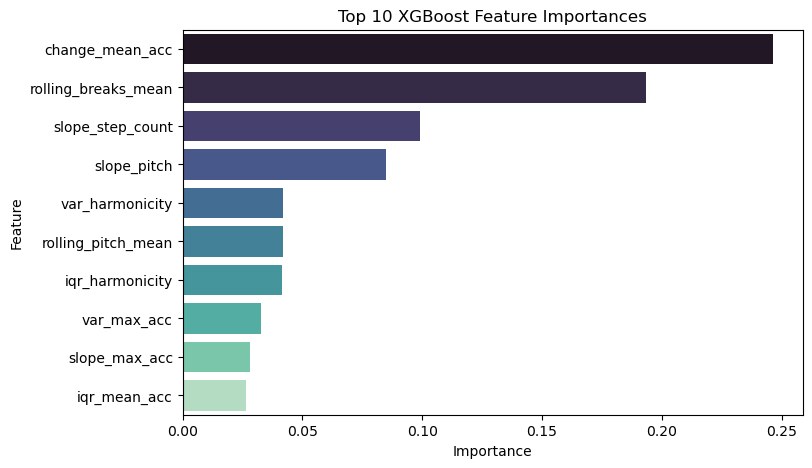

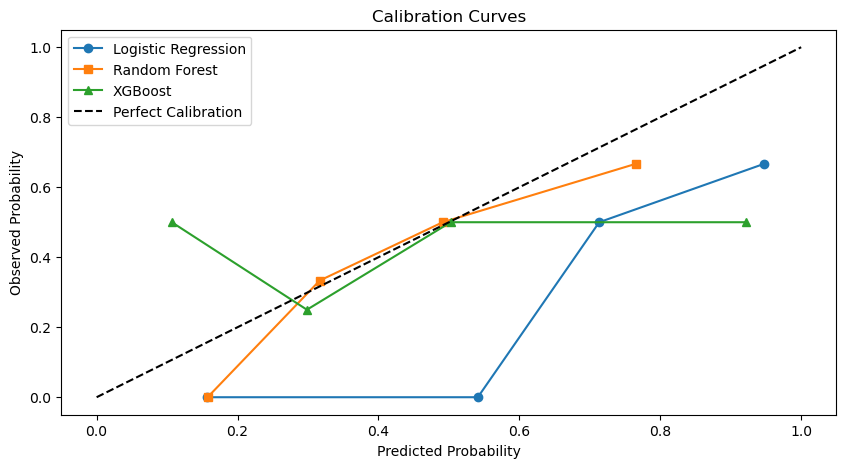

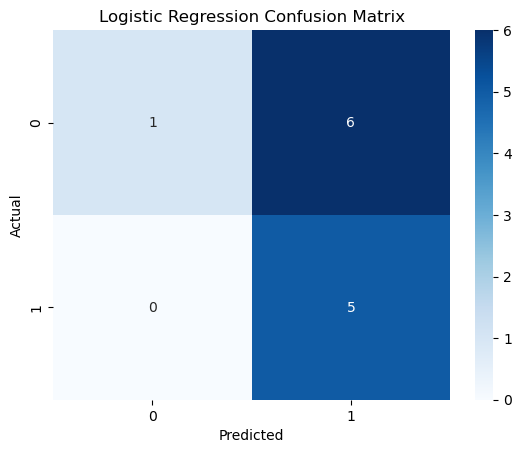


=== Logistic Regression Misclassification Report ===
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.45      1.00      0.62         5

    accuracy                           0.50        12
   macro avg       0.73      0.57      0.44        12
weighted avg       0.77      0.50      0.41        12



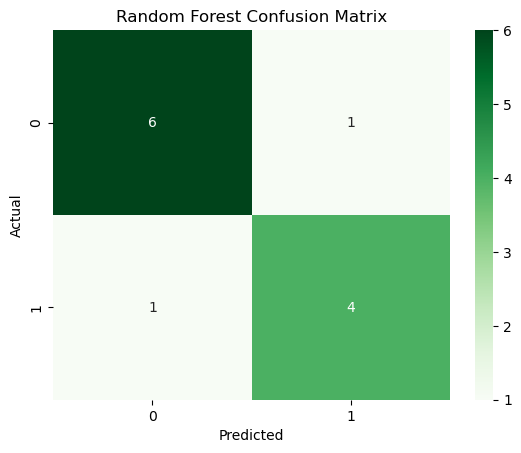


=== Random Forest Misclassification Report ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------
# 1. Logistic Regression: Odds Ratios
# ---------------------------
odds_ratios = pd.DataFrame({
    "Feature": X_log.columns,
    "OddsRatio": np.exp(log_reg.coef_[0])
}).sort_values(by="OddsRatio", ascending=False)

print("\n=== Logistic Regression Odds Ratios ===")
print(odds_ratios)

# ---------------------------
# 2. Feature Importance (Random Forest + XGBoost)
# ---------------------------

# Random Forest Feature Importances
rf_importances = pd.DataFrame({
    "Feature": X_rf.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n=== Random Forest Feature Importances ===")
print(rf_importances.head(10))

# Plot RF importance
plt.figure(figsize=(8,5))
sns.barplot(data=rf_importances.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Random Forest Feature Importances")
plt.show()

# XGBoost Feature Importances
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_rf, y_train_rf)

xgb_importances = pd.DataFrame({
    "Feature": X_rf.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n=== XGBoost Feature Importances ===")
print(xgb_importances.head(10))

plt.figure(figsize=(8,5))
sns.barplot(data=xgb_importances.head(10), x="Importance", y="Feature", palette="mako")
plt.title("Top 10 XGBoost Feature Importances")
plt.show()

# ---------------------------
# 3. Calibration Curves
# ---------------------------

plt.figure(figsize=(10,5))

# Logistic Regression
y_prob_log = log_reg.predict_proba(X_test_log)[:,1]
prob_true_log, prob_pred_log = calibration_curve(y_test_log, y_prob_log, n_bins=5)

plt.plot(prob_pred_log, prob_true_log, marker='o', label="Logistic Regression")

# Random Forest
y_prob_rf = rf.predict_proba(X_test_rf)[:,1]
prob_true_rf, prob_pred_rf = calibration_curve(y_test_rf, y_prob_rf, n_bins=5)

plt.plot(prob_pred_rf, prob_true_rf, marker='s', label="Random Forest")

# XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test_rf)[:,1]
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test_rf, y_prob_xgb, n_bins=5)

plt.plot(prob_pred_xgb, prob_true_xgb, marker='^', label="XGBoost")

# Reference line (perfect calibration)
plt.plot([0,1],[0,1],'k--', label="Perfect Calibration")

plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curves")
plt.legend()
plt.show()

# ---------------------------
# 4. Error Analysis
# ---------------------------

# Logistic Regression Confusion Matrix
cm_log = confusion_matrix(y_test_log, log_reg.predict(X_test_log))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Logistic Regression Misclassification Report ===")
print(classification_report(y_test_log, log_reg.predict(X_test_log)))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test_rf, rf.predict(X_test_rf))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n=== Random Forest Misclassification Report ===")
print(classification_report(y_test_rf, rf.predict(X_test_rf)))


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score

# ========================
# Step 1: Define "important" features
# ========================
selected_features = [
    "MD_score", "MD_outlier",
    "rolling_vol_acc", "rolling_pitch_vol", "rolling_breaks_vol",
    "slope_pitch", "slope_max_acc",
    "rolling_breaks_mean", "rolling_harm_mean", "rolling_mean_acc",
    "change_step_count", "slope_step_count", "rolling_pitch_mean",
    "slope_mean_acc", "iqr_harmonicity", "iqr_steps"
]

# Make sure they exist in your dataset
selected_features = [f for f in selected_features if f in master.columns]

# Target
y = master["outcome"]

# ========================
# Logistic Regression
# ========================
X_log = master[selected_features]
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log_scaled, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = LogisticRegression(max_iter=500, solver="liblinear")
log_reg.fit(X_train_log, y_train_log)
y_pred_log = log_reg.predict(X_test_log)
y_proba_log = log_reg.predict_proba(X_test_log)[:, 1]

print("=== Logistic Regression (Selected Features) ===")
print("Accuracy:", accuracy_score(y_test_log, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test_log, y_proba_log))
print("F1:", f1_score(y_test_log, y_pred_log))
print(classification_report(y_test_log, y_pred_log))

# ========================
# Random Forest
# ========================
X_rf = master[selected_features]
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
y_proba_rf = rf.predict_proba(X_test_rf)[:, 1]

print("\n=== Random Forest (Selected Features) ===")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test_rf, y_proba_rf))
print("F1:", f1_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))

# ========================
# XGBoost
# ========================
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_rf, y_train_rf)
y_pred_xgb = xgb.predict(X_test_rf)
y_proba_xgb = xgb.predict_proba(X_test_rf)[:, 1]

print("\n=== XGBoost (Selected Features) ===")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test_rf, y_proba_xgb))
print("F1:", f1_score(y_test_rf, y_pred_xgb))
print(classification_report(y_test_rf, y_pred_xgb))


=== Logistic Regression (Selected Features) ===
Accuracy: 0.8333333333333334
ROC AUC: 0.9142857142857144
F1: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.71      1.00      0.83         5

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12


=== Random Forest (Selected Features) ===
Accuracy: 0.75
ROC AUC: 0.8285714285714286
F1: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.75      0.60      0.67         5

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12


=== XGBoost (Selected Features) ===
Accuracy: 0.5833333333333334
ROC AUC: 0.7142857142857143
F1: 0.444444444

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# =========================
# Prepare Data
# =========================
drop_feats = [col for col in master.columns if col.startswith("change_")] + [
    "rolling_breaks_mean", "rolling_harm_mean"
]
master_2 = master.drop(columns=drop_feats)

X = master_2.drop(columns=["subject_id", "sex", "age", "diagnosis_date", "age_bin", "outcome"])
y = master_2["outcome"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# Stratified 5-Fold CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []

for train_idx, val_idx in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LogisticRegression(
        C=0.1, penalty="l2", solver="liblinear", random_state=42
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    auc_scores.append(roc_auc_score(y_val, y_prob))
    f1_scores.append(f1_score(y_val, y_pred))
    prec_scores.append(precision_score(y_val, y_pred))
    rec_scores.append(recall_score(y_val, y_pred))

# =========================
# Results
# =========================
print("=== Stratified 5-Fold CV (Logistic Regression) ===")
print(f"ROC AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
print(f"F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Precision: {np.mean(prec_scores):.3f} ± {np.std(prec_scores):.3f}")
print(f"Recall: {np.mean(rec_scores):.3f} ± {np.std(rec_scores):.3f}")


=== Stratified 5-Fold CV (Logistic Regression) ===
ROC AUC: 0.841 ± 0.078
F1 Score: 0.622 ± 0.313
Precision: 0.586 ± 0.296
Recall: 0.670 ± 0.346


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# -----------------------------
# Stratified 5-Fold CV for Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,               # tuned from before
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results_rf = cross_validate(rf, X_rf, y_rf, cv=cv, scoring=scoring)

# Print mean ± std results
print("=== Stratified 5-Fold CV (Random Forest) ===")
for metric in scoring.keys():
    scores = cv_results_rf[f'test_{metric}']
    print(f"{metric.upper()}: {scores.mean():.3f} ± {scores.std():.3f}")


=== Stratified 5-Fold CV (Random Forest) ===
ROC_AUC: 0.853 ± 0.064
F1: 0.680 ± 0.132
PRECISION: 0.820 ± 0.165
RECALL: 0.620 ± 0.204


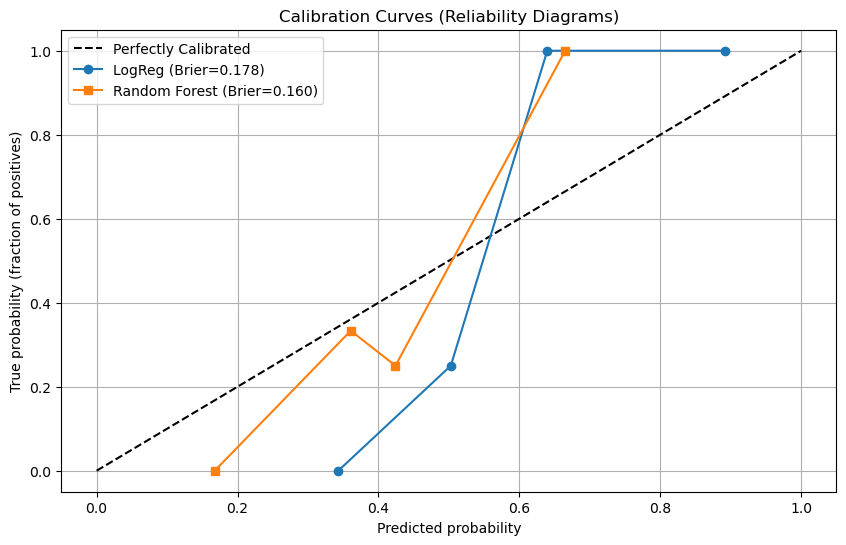

In [80]:
# ================================
# 1. Refit Logistic Regression
# ================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---- Logistic Regression dataset (after feature selection) ----
X_log = master_2.drop(columns=["subject_id", "sex", "age", "diagnosis_date", "age_bin", "outcome"])
y_log = master_2["outcome"]

scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log_scaled, y_log, test_size=0.2, random_state=42, stratify=y_log
)

log_reg = LogisticRegression(C=0.1, penalty="l2", solver="liblinear", max_iter=1000)
log_reg.fit(X_train_log, y_train_log)


# ================================
# 2. Refit Random Forest
# ================================
X_rf = master_2.drop(columns=["subject_id", "sex", "age", "diagnosis_date", "age_bin", "outcome"])
y_rf = master_2["outcome"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

rf = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf.fit(X_train_rf, y_train_rf)


# ================================
# 3. Calibration Evaluation
# ================================
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Logistic Regression
y_proba_log = log_reg.predict_proba(X_test_log)[:, 1]
prob_true_log, prob_pred_log = calibration_curve(y_test_log, y_proba_log, n_bins=5, strategy='uniform')
brier_log = brier_score_loss(y_test_log, y_proba_log)

# Random Forest
y_proba_rf = rf.predict_proba(X_test_rf)[:, 1]
prob_true_rf, prob_pred_rf = calibration_curve(y_test_rf, y_proba_rf, n_bins=5, strategy='uniform')
brier_rf = brier_score_loss(y_test_rf, y_proba_rf)

# Plot calibration curves
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.plot(prob_pred_log, prob_true_log, marker='o', label=f"LogReg (Brier={brier_log:.3f})")
plt.plot(prob_pred_rf, prob_true_rf, marker='s', label=f"Random Forest (Brier={brier_rf:.3f})")

plt.xlabel("Predicted probability")
plt.ylabel("True probability (fraction of positives)")
plt.title("Calibration Curves (Reliability Diagrams)")
plt.legend()
plt.grid(True)
plt.show()
